### A simple linear regression model of sales vs marketing spends

In [54]:
# Importing libraries

from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
import pandas as pd
import matplotlib.pyplot as plt


In [11]:
# Importing the dataset

data = pd.read_csv(
    'https://raw.githubusercontent.com/Garve/datasets/4576d323bf2b66c906d5130d686245ad205505cf/mmm.csv',
    parse_dates=['Date'],
    index_col='Date'
)


In [16]:
X = data.drop(columns=['Sales'])
y = data['Sales']
lr = LinearRegression()

print('fold wise scores:',cross_val_score(lr, X, y, cv=TimeSeriesSplit()))
print('average score:',cross_val_score(lr, X, y, cv=TimeSeriesSplit()).mean())

fold wise scores: [0.69594303 0.69302285 0.66850729 0.78807363 0.73512387]
average score: 0.7161341347467671


In [20]:
lr.fit(X, y) # refit the model with the complete dataset
print('Coefficients:', lr.coef_)
print('Intercept:', lr.intercept_)


Coefficients: [0.35968382 0.48833246 1.2159193 ]
Intercept: 6678.396933606162


In [22]:
print(lr.predict(([[8045.44, 4310.55, 1992.98]])))

# Actual value is 13527.65

[14100.49588453]


In [47]:
weights = pd.Series(lr.coef_,index=X.columns)

base = lr.intercept_

unadjusted_contri = (X*weights).assign(Base=base)

unadjusted_contri_wsales = pd.concat((unadjusted_contri,y),axis=1)

unadjusted_contri_wsales['adjustment_factor'] = (unadjusted_contri_wsales['Sales'])/(unadjusted_contri_wsales['Base']+unadjusted_contri_wsales['TV']+unadjusted_contri_wsales['Radio']+unadjusted_contri_wsales['Banners'])


In [48]:
unadjusted_contri_wsales

,TV,Radio,Banners,Base,Sales,adjustment_factor
Date,,,,,,
2018-01-07,4865.838699,0.000000,0.000000,6678.396934,9779.80,0.847159
2018-01-14,0.000000,2612.407764,2698.039815,6678.396934,13245.19,1.104793
2018-01-21,0.000000,2068.507949,2488.938173,6678.396934,12022.66,1.070027
2018-01-28,0.000000,1739.542785,0.000000,6678.396934,8846.95,1.050964
2018-02-04,0.000000,0.000000,2659.568129,6678.396934,9797.07,1.049165
...,...,...,...,...,...,...
2021-10-03,0.000000,0.000000,2056.946364,6678.396934,9030.17,1.033751
2021-10-10,4152.038962,2253.825236,3062.754810,6678.396934,15904.11,0.984957
2021-10-17,0.000000,2224.920837,2333.580164,6678.396934,12839.29,1.142601


### Sales contribution from each channel

In [49]:
unadjusted_contri_wsales['Base_proportion'] = unadjusted_contri_wsales['Base']*unadjusted_contri_wsales['adjustment_factor']/unadjusted_contri_wsales['Sales']
unadjusted_contri_wsales['TV_proportion'] = unadjusted_contri_wsales['TV']*unadjusted_contri_wsales['adjustment_factor']/unadjusted_contri_wsales['Sales']
unadjusted_contri_wsales['Radio_proportion'] = unadjusted_contri_wsales['Radio']*unadjusted_contri_wsales['adjustment_factor']/unadjusted_contri_wsales['Sales']
unadjusted_contri_wsales['Banners_proportion'] = unadjusted_contri_wsales['Banners']*unadjusted_contri_wsales['adjustment_factor']/unadjusted_contri_wsales['Sales']


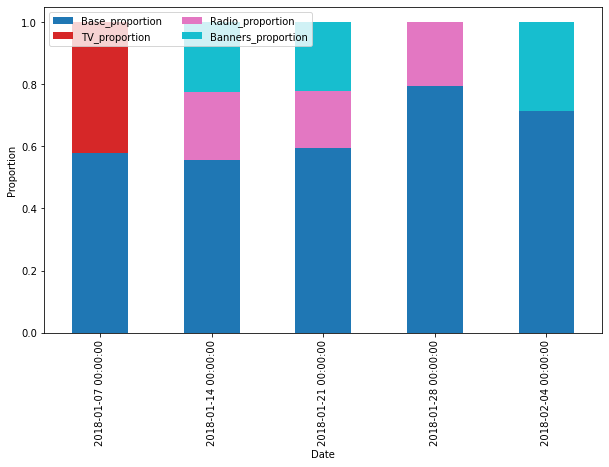

In [56]:
# we can get the marketing contributions at whatever level the data was modeled

unadjusted_contri_wsales[['Base_proportion','TV_proportion','Radio_proportion','Banners_proportion']].head().plot(kind='bar', 
                    stacked=True, 
                    colormap='tab10', 
                    figsize=(10, 6))

plt.legend(loc="upper left", ncol=2)
plt.xlabel("Date")
plt.ylabel("Proportion")
plt.show()

In [64]:
# we can also get overall contribution for directional impact

print('Base:',sum(unadjusted_contri_wsales['Base']*unadjusted_contri_wsales['adjustment_factor'])/sum(unadjusted_contri_wsales['Sales']))
print('TV:',sum(unadjusted_contri_wsales['TV']*unadjusted_contri_wsales['adjustment_factor'])/sum(unadjusted_contri_wsales['Sales']))
print('Radio:',sum(unadjusted_contri_wsales['Radio']*unadjusted_contri_wsales['adjustment_factor'])/sum(unadjusted_contri_wsales['Sales']))
print('Banners:',sum(unadjusted_contri_wsales['Banners']*unadjusted_contri_wsales['adjustment_factor'])/sum(unadjusted_contri_wsales['Sales']))


Base: 0.6257865172317281
TV: 0.09948842503607648
Radio: 0.10156790592957479
Banners: 0.1731571518026206


In [65]:
sales_from_tv = sum(unadjusted_contri_wsales['TV']*unadjusted_contri_wsales['adjustment_factor'])
spendings_on_tv = data['TV'].sum()
tv_roi = sales_from_tv / spendings_on_tv
tv_roi

0.3602450071355312

### Ways to improve model through feature engineering

#### 1) Increasing marketing does not lead to infinite increase in sales. Effect of marketing has a saturation point. This can be modeled using a simple 1-exp(-ax) curve. Here a has to be decided. 

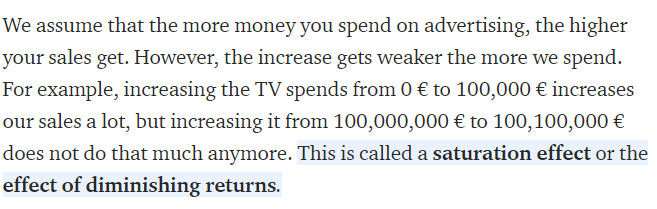

#### 2) Introduce adstock transformation - this models promotional effect more accurately, i.e. once you see a TV ad this week you may remember it next week also. Adstock requires - % of information carried over (eg: 50%), number of weeks it is carried over for 

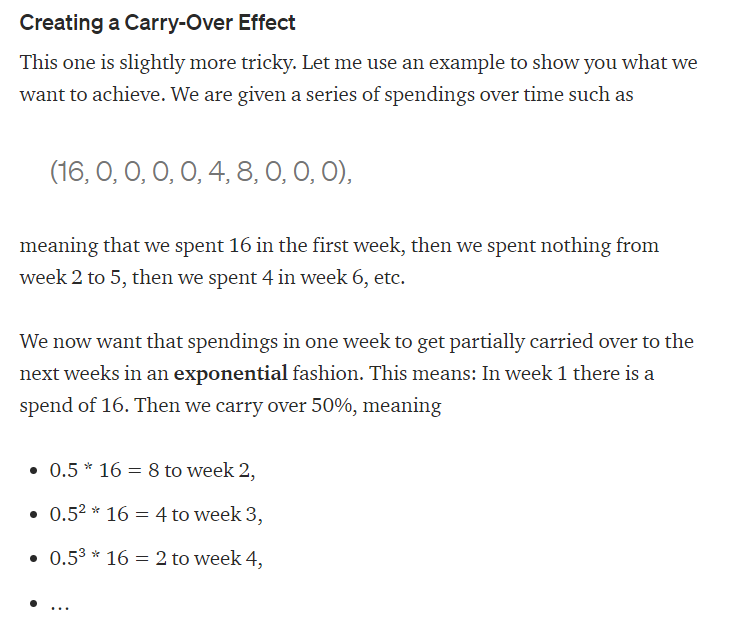

### After generating these features we can do a simple gridsearch to see which set of hyper parameters or transformation combinations gives us the best fit. This will also give us an indication of the effect the channel has on audience, i.e. saturation phase of channel, recall value the channel has on audience memory